# Baseline Keras CNN with 160k samples
Heavily inspired by https://www.kaggle.com/hrmello/cnn-classification-80-accuracy

Thanks to @Marsh for https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [5]:
import tensorflow as tf

In [10]:
DATADIR = '../../input/'
OUTDIR = '../../histo/'

# Load data

In [14]:
base_tile_dir = DATADIR + 'train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv(DATADIR + "train_labels.csv")
df_data = df.merge(labels, on = "id")

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df_data.head(3)

,path,id,label
0,../../input/train/ec513dee6b0e06af63f234ce1a0f...,ec513dee6b0e06af63f234ce1a0f62002f944ffd,1
1,../../input/train/f908e555363ed81f4fa3713e2851...,f908e555363ed81f4fa3713e2851a03e75d14c0a,1
2,../../input/train/0d12a52062cd967583f4cd223498...,0d12a52062cd967583f4cd223498fe37f8a2885b,1


# Split X and y in train/test and build folders

In [15]:
SAMPLE_SIZE = 1000 # load 1k negative examples

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

# Create directories
train_path = OUTDIR + 'train'
valid_path = OUTDIR + 'dev'
test_path = DATADIR + 'test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [16]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,path,label
id,,
348dac33612805543578f6abd6726d95d9a8c4d8,../../input/train/348dac33612805543578f6abd672...,0
fb78940aa0c4dbfe26b085a043b9e661e97ad7bf,../../input/train/fb78940aa0c4dbfe26b085a043b9...,1
eafd7247f69868909706e28dc0d8d30e9247c4ef,../../input/train/eafd7247f69868909706e28dc0d8...,0
1aeb6c98daf65ae63b48ba26ecc14adc06bbd4ae,../../input/train/1aeb6c98daf65ae63b48ba26ecc1...,0
d132fa3cad65a8275d80af1924f4e31da90bcf8a,../../input/train/d132fa3cad65a8275d80af1924f4...,0


In [17]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join(DATADIR + 'train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join(DATADIR + 'train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)


In [18]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Define the model 
**Model structure (optimizer: Adam):**

* In 
* [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 16, 32, 64)
* Flatten 
* Dense (256) 
* Dropout 
* Out

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

# Train

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=13,
                   callbacks=[reducel, earlystopper])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/13
57/57 [==============================] - 45s 788ms/step - loss: 0.6837 - accuracy: 0.6789 - val_loss: 5.9340 - val_accuracy: 0.4950
Epoch 2/13
57/57 [==============================] - 44s 778ms/step - loss: 0.5539 - accuracy: 0.7411 - val_loss: 4.0491 - val_accuracy: 0.4750
Epoch 3/13
57/57 [==============================] - 44s 777ms/step - loss: 0.5386 - accuracy: 0.7639 - val_loss: 0.5214 - val_accuracy: 0.7650
Epoch 4/13
57/57 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.7628
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
57/57 [==============================] - 44s 778ms/step - loss: 0.5282 - accuracy: 0.7628 - val_loss: 0.6242 - val_accuracy: 0.7000
Epoch 5/13
57/57 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.7867
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model

In [21]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

Instructions for updating:
Please use Model.predict, which supports generators.
200/200 [==============================] - 1s 7ms/step


0.8065000000000001

# Plot ROC Curve

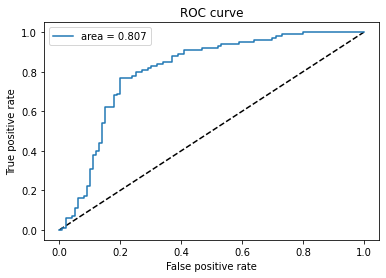

In [22]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Load test data and predict
I could not find a smart way to do this without crashing the Kernel (due to MemoryError). So I just load the test files in batches, predict, and concatenate the results.

In [ ]:
pd.read_csv("submission.csv")

In [ ]:
base_test_dir = 'test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

In [ ]:
#submission
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree(train_path)
shutil.rmtree(valid_path)
submission.to_csv("submission.csv", index = False, header = True)